# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [3]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
# !unzip Train_rev1.zip
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [4]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is **fat-tailed（肥尾分布，出现极端值的概率比正态分布要大）** on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

In [5]:
# log1p: calculates log(1+x), more accurate for small values.
a = 1e-99
l = np.log(1.0+a)
print(l)
lp = np.log1p(a)
print(lp)

0.0
1e-99


(array([  447.,   267.,   521.,   617.,  5549., 13070., 19634., 22832.,
        33119., 35579., 36994., 28050., 16408., 17527.,  7096.,  5505.,
         1309.,   135.,    64.,    45.]),
 array([ 8.517193 ,  8.701637 ,  8.886081 ,  9.070525 ,  9.254969 ,
         9.439413 ,  9.623857 ,  9.808301 ,  9.992744 , 10.177189 ,
        10.361633 , 10.546077 , 10.730521 , 10.914965 , 11.099409 ,
        11.283853 , 11.468297 , 11.6527405, 11.837185 , 12.021628 ,
        12.206073 ], dtype=float32),
 <BarContainer object of 20 artists>)

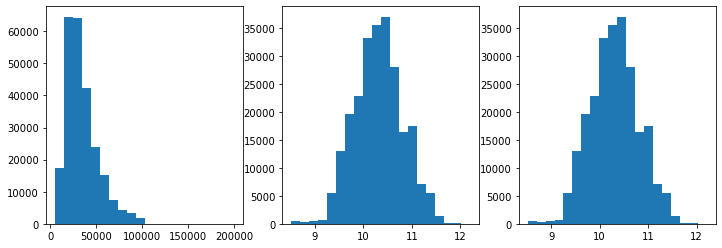

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')
log_test = np.log(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[12, 4])
plt.subplot(1, 3, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 3, 2)
plt.hist(data['Log1pSalary'], bins=20);

plt.subplot(1, 3, 3)
plt.hist(log_test, bins=20)

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [7]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
125837,69993935,Chartered Structural Engineer,Job Title: Chartered Structural Engineer Locat...,Helensburgh Dunbartonshire Scotland,UK,NaN,permanent,Forces Recruitment Services,Engineering Jobs,"From 35,675 to 41,338 per annum plus Benefits",38506,totaljobs.com,10.558596
143697,70623750,Staff Nurse,Staff Nurse Newly qualified considered Steven...,Stevenage Hertfordshire South East,UK,NaN,permanent,Green Care Management,Healthcare & Nursing Jobs,23000 - 25000 per annum,24000,totaljobs.com,10.085851
76205,69006180,Physics Lecturer,ADVERT REFERENCE: (RM1803378) JOB TITLE: Lect...,Greater Manchester,Manchester,part_time,NaN,Protocol National,Teaching Jobs,16 - 17/hour Plus Statutory Holiday Pay,31680,cv-library.co.uk,10.363472


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [8]:
print("Raw text:")
print(data["FullDescription"][2::20000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
20002     ADVERT REFERENCE:  CD  **** JOB TITLE: Mechani...
40002     Software Developer  C, SQL  Gloucestershire  *...
60002     Payroll Officer Required for an exciting new r...
80002     I am currently seeking a GIS Technician. A key...
100002    A successful and high achieving specialist sch...
120002    Network Technical Operations Engineers require...
140002    Chef de Partie required for a NEW OPENING for ...
160002    Our client is seeking an experienced Credit or...
180002    Demandware, ATG, IBM Websphere Commerce, Hybri...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
220002    FINTEC recruit is seeking a ROV Sub Engineer f...
240002    Our award winning client works with some of th...
Name: FullDescription, dtype: object


In [9]:
import nltk
from tqdm import tqdm
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE
for idx in tqdm(range(len(data["FullDescription"]))):
    tokenized = tokenizer.tokenize(str(data["FullDescription"][idx]).lower())
    new_des = ' '.join(tokenized)
    data["FullDescription"][idx] = new_des

for idx in tqdm(range(len(data["Title"]))):
    tokenized = tokenizer.tokenize(str(data["Title"][idx]).lower())
    new_title = ' '.join(tokenized)
    data["Title"][idx] = new_title

  0%|                                                                                       | 0/244768 [00:00<?, ?it/s]<ipython-input-9-53ae85fe3ba0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["FullDescription"][idx] = new_des
  0%|                                                                                       | 0/244768 [00:00<?, ?it/s]<ipython-input-9-53ae85fe3ba0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Title"][idx] = new_title
100%|█████████████████████████████████████████████████████████████████████████| 244768/244768 [06:56<00:00, 587.51it/s]


Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
from collections import Counter
title_text = [word for title in data["Title"] for word in str(title).split(' ')]        # list comprehension: for outer-loop  --> for inner-loop
des_text = [word for des in data["FullDescription"] for word in str(des).split(' ')]
title_counts = Counter(title_text)
des_counts = Counter(des_text)
token_counts = title_counts + des_counts

In [12]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


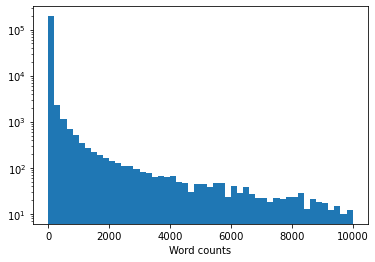

In [13]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [61]:
# start from here
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"
data = pd.read_csv("new_Train_rev1.csv")
print(data.head())

title_text = [word for title in data["Title"] for word in str(title).split(' ')]        # list comprehension: for outer-loop  --> for inner-loop
des_text = [word for des in data["FullDescription"] for word in str(des).split(' ')]
title_counts = Counter(title_text)
des_counts = Counter(des_text)
token_counts = title_counts + des_counts

   Unnamed: 0        Id                                              Title  \
0           0  12612628                        engineering systems analyst   
1           1  12612830                            stress engineer glasgow   
2           2  12612844                   modelling and simulation analyst   
3           3  12613049  engineering systems analyst / mathematical mod...   
4           4  12613647        pioneer , miser engineering systems analyst   

                                     FullDescription  \
0  engineering systems analyst dorking surrey sal...   
1  stress engineer glasgow salary **** to **** we...   
2  mathematical modeller / simulation analyst / o...   
3  engineering systems analyst / mathematical mod...   
4  pioneer , miser engineering systems analyst do...   

                         LocationRaw LocationNormalized ContractType  \
0            Dorking, Surrey, Surrey            Dorking          NaN   
1        Glasgow, Scotland, Scotland            Gl

MemoryError: 

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [35]:
# min_count = 10
# 
# # tokens from token_counts keys that had at least min_count occurrences throughout the dataset
# tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# # Add a special tokens for unknown and empty words
# UNK, PAD = "UNK", "PAD"
# tokens = [UNK, PAD] + tokens

min_count = 10
tokens = sorted((t for t, c in token_counts.items() if c >= min_count), key=lambda t: token_counts[t], reverse=True)
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [36]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [37]:
# token_to_id = {t: i for i, t in enumerate(tokens)}#TODO<your code here>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [38]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [39]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding 
    @param sequences: a list of sentences.
    @param max_len: max length of sentences.
    @return matrix: matrix of tokens' index.
    """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))  # convert list of string sentences to list of list of tokens
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))  # firstly, create a new matrix full of PAD_IDX
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]  # sentence to list of token-idx
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [40]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[ 136  114  269    1    1]
 [ 311  236    1    1    1]
 [ 100 4120  135  388   83]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [41]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

"""
DictVectorizer: convert data to one-hot-likely encodes.
data[categorical_columns]: pd.Series(["UK", "IBM", "ARM", ...]),
apply(dict, axis=1): pd.Series(["LocationNormalized: UK", "Company: IBM", ...]), the data[...] "..." has to be a list
fit: convert string values to int class-values.
"""
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [60]:
b = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
print(data["Category"][171635])
print(b[171635][0:28])  # 0~28, category related.
print(b.shape)  # every categorical vector: 3768d multi-hot vector

Manufacturing Jobs
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(244768, 3768)


### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [23]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [62]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cuda:0')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)  # pd.Series.values: array of values
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch["target_column"] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [63]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[  100,    52,   712,     1,     1,     1,     1],
         [ 2110,    17,  3786,  5286,     9,  1391, 21015],
         [ 2911,    31,   347,    35, 12300, 12981,    44]], device='cuda:0'),
 'FullDescription': tensor([[  100,    52,   712,  2712,     7,   100,    52,   712,    16,  2712],
         [ 2110,    17,  3786,  5286,     9,  1391, 21015,   969,    23,    13],
         [    5,    59,   188,    42,    16,   168,   279,     7,    31,   347]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'target_column': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F

In [ ]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        #  YOUR CODE HERE
        
        
    def forward(self, batch):
        # YOUR CODE HERE
        
        

In [ ]:
model = SalaryPredictor()

In [ ]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=torch.device('cpu'), **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [ ]:
import tqdm

BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device('cpu')

In [ ]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_y)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [ ]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val)

      

### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [ ]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)